<a id="introduction"></a>
## Introduction to Dask using cuDF DataFrames
#### By Paul Hendricks
-------

In this notebook, we will show how to work with cuDF DataFrames using Dask.

**Table of Contents**

* [Introduction to Dask using cuDF DataFrames](#introduction)
* [Setup](#setup)
* [Using cuDF DataFrames with Dask](#using)
* [Conclusion](#conclusion)

<a id="setup"></a>
## Setup

This notebook was tested using the following Docker containers:

* `rapidsai/rapidsai-dev-nightly:0.10-cuda10.0-devel-ubuntu18.04-py3.7` container from [DockerHub](https://hub.docker.com/r/rapidsai/rapidsai-nightly)

This notebook was run on the NVIDIA GV100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here: https://github.com/rapidsai/notebooks-contrib/issues

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [1]:
!nvidia-smi

Thu Sep 22 21:29:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:2F:00.0 Off |                  Off |
| 30%   57C    P8    34W / 300W |  13276MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:41:00.0 Off |                  Off |
| 30%   

Next, let's see what CUDA version we have:

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


## Install graphviz
The visualizations in this notebook require graphviz.  Your environment may not have it installed, but don't worry! If you don't, we're going to install it now.  This can take a little while, so sit tight.

In [3]:
import os
try:
    import graphviz
except ModuleNotFoundError:
    os.system('apt update')
    os.system('apt install -y graphviz')
    os.system('conda install -c conda-forge graphviz -y')
    os.system('conda install -c conda-forge python-graphviz -y')

Let's start by creating a local cluster of workers and a client to interact with that cluster.

In [4]:
from dask.distributed import Client
from dask_cuda import LocalCUDACluster


# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)
client

2022-09-22 21:29:03,927 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2022-09-22 21:29:03,936 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 503.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35693,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 503.53 GiB
Comm: tcp://127.0.0.1:40331,Total threads: 1
Dashboard: http://127.0.0.1:40707/status,Memory: 251.76 GiB
Nanny: tcp://127.0.0.1:44661,


We'll define a function called `load_data` that will create a `cudf.DataFrame` with two columns, `key` and `value`. The column `key` will be randomly filled with either a 0 or a 1, with 50% probability of either number being selected. The column `value` will be randomly filled with numbers sampled from a normal distribution.

In [5]:
import cudf; print('cuDF Version:', cudf.__version__)
import numpy as np; print('NumPy Version:', np.__version__)


def load_data(n_rows):
    df = cudf.DataFrame()
    random_state = np.random.RandomState(43210)
    df['key'] = random_state.binomial(n=1, p=0.5, size=(n_rows,))
    df['value'] = random_state.normal(size=(n_rows,))
    return df

cuDF Version: 22.06.00a+319.g97422602b8
NumPy Version: 1.22.4


We'll also define a function `head` that takes a `cudf.DataFrame` and returns the first 5 rows.

In [6]:
def head(dataframe):
    return dataframe.head()

We'll define the number of workers as well as the number of rows each dataframe will have.

In [7]:
# define the number of workers
n_workers = 4  # feel free to change this depending on how many GPUs you have

# define the number of rows each dataframe will have
n_rows = 125000000  # we'll use 125 million rows in each dataframe

We'll create each dataframe using the `delayed` operator. 

In [8]:
from dask.delayed import delayed


# create each dataframe using a delayed operation
dfs = [delayed(load_data)(n_rows) for i in range(n_workers)]
dfs

[Delayed('load_data-75b0c0be-6301-42d5-9600-dc12ad772ce0'),
 Delayed('load_data-0ec87d6d-1641-49be-b5e8-eab6ae86b5d3'),
 Delayed('load_data-599f1405-10e9-485f-933b-352a95d95b20'),
 Delayed('load_data-362465b9-3273-4cd2-a6fb-0ba10b2dc422')]

We see the result of this operation is a list of `Delayed` objects. It's important to note that these operations are "delayed" - nothing has been computed yet, meaning our data has not yet been created!

We can apply the `head` function to each of our "delayed" dataframes.

In [9]:
head_dfs = [delayed(head)(df) for df in dfs]
head_dfs

[Delayed('head-c2d5d85b-85e1-43e4-a952-70c99cff8af8'),
 Delayed('head-69915368-60dd-4733-b68f-088fd4af5bd5'),
 Delayed('head-3f10c86b-a07d-4249-aff8-c993c4c836f0'),
 Delayed('head-e6e004d6-1de1-4f43-af30-b4dbea784c9f')]

As before, we see that the result is a list of `Delayed` objects - an important thing to note is that our "key", or unique identifier for each operation, has changed. You should see the name of the function `head` followed by a hash sign. For example, one might see:

```
[Delayed('head-8e946db2-feaf-4e79-99ab-f732b6e28461'),
 Delayed('head-eb06bc77-9d5c-4a47-8c01-b5b36710b727'),
 Delayed('head-e1c976c8-3f94-4a01-8300-41def5117f93'),
 Delayed('head-7d0a7201-a973-4846-a68f-cb6f85b25076')]
```

Again, nothing has been computed - let's compute the results and execute the workflow using the `client.compute()` method.

In [10]:
from dask.distributed import wait


# use the client to compute - this means create each dataframe and take the head
futures = client.compute(head_dfs)
wait(futures)  # this will give Dask time to execute the work before moving to any subsequently defined operations
futures

[<Future: finished, type: cudf.core.dataframe.DataFrame, key: head-c2d5d85b-85e1-43e4-a952-70c99cff8af8>,
 <Future: finished, type: cudf.core.dataframe.DataFrame, key: head-69915368-60dd-4733-b68f-088fd4af5bd5>,
 <Future: finished, type: cudf.core.dataframe.DataFrame, key: head-3f10c86b-a07d-4249-aff8-c993c4c836f0>,
 <Future: finished, type: cudf.core.dataframe.DataFrame, key: head-e6e004d6-1de1-4f43-af30-b4dbea784c9f>]

We see that our results are a list of futures. Each object in this list tells us a bit information about itself: the status (pending, error, finished), the type of the object, and the key (unique identifief).

We can use the `client.gather` method to collect the results of each of these futures.

In [11]:
# collect the results
results = client.gather(futures)
results

[   key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184,
    key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184,
    key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184,
    key     value
 0    1  0.689155
 1    0  0.999085
 2    0 -0.277850
 3    1 -1.535017
 4    1 -0.028184]

We see that our results are a list of cuDF DataFrames, each having 2 columns and 5 rows. Let's inspect the first dataframe:

In [12]:
# let's inspect the head of the first dataframe
print(results[0])

   key     value
0    1  0.689155
1    0  0.999085
2    0 -0.277850
3    1 -1.535017
4    1 -0.028184


Voila! 

That was a pretty simple example. Let's see how we can use this perform a more complex operation like figuring how many total rows we have across all of our dataframes. We'll define a function called `length` that will take a `cudf.DataFrame` and return the first value of the `shape` attribute i.e. the number of rows for that particular dataframe.

In [13]:
def length(dataframe):
    return dataframe.shape[0]

We'll define our operation on the dataframes we've created:

In [14]:
lengths = [delayed(length)(df) for df in dfs]

And then use Python's built-in `sum` function to sum all of these lengths.

In [15]:
total_number_of_rows = delayed(sum)(lengths)

At this point, `total_number_of_rows` hasn't been computed yet. But we can still visualize the graph of operations we've defined using the `visualize()` method.

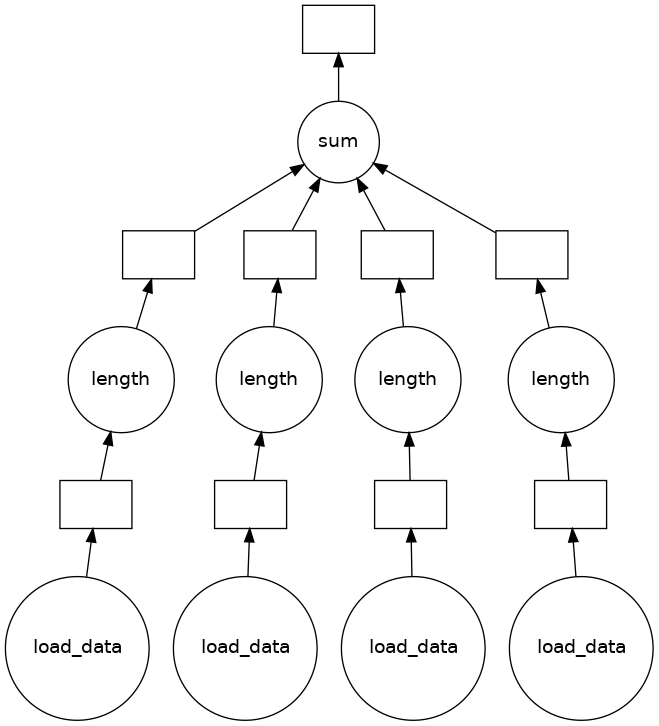

In [16]:
total_number_of_rows.visualize()

The graph can be read from bottom to top. We see that for each worker, we will first execute the `load_data` function to create each dataframe. Then the function `length` will be applied to each dataframe; the results from these operations on each worker will then be combined into a single result via the `sum` function. 

Let's now execute our workflow and compute a value for the `total_number_of_rows` variable.

In [17]:
# use the client to compute the result and wait for it to finish
future = client.compute(total_number_of_rows)
wait(future)
future

<Future: finished, type: int, key: sum-9daf42cd-9a89-4c9f-9740-0cfbf8d8139a>

We see that our computation has finished - our result is of type `int`. We can collect our result using the `client.gather()` method.

In [18]:
# collect result
result = client.gather(future)
result

500000000

That's all there is to it! We can define even more complex operations and workflows using cuDF DataFrames by using the `delayed`, `wait`, `client.submit()`, and `client.gather()` workflow.

However, there can sometimes be a drawback from using this pattern. For example, consider a common operation such as a groupby - we might want to group on certain keys and aggregate the values to compute a mean, variance, or even more complex aggregations. Each dataframe is located on a different GPU - and we're not guaranteed that all of the keys necessary for that groupby operation are located on a single GPU i.e. keys may be scattered across multiple GPUs. 

To make our problem even more concrete, let's consider the simple operation of grouping on our `key` column and calculating the mean of the `value` column. To sovle this problem, we'd have to sort the data and transfer keys and their associated values from one GPU to another - a tricky thing to do using the delayed pattern. In the example below, we'll show an example of this issue with the delayed pattern and motivate why one might consider using the `dask_cudf` API.

First, let's define a function `groupby` that takes a `cudf.DataFrame`, groups by the `key` column, and calculates the mean of the `value` column.

In [19]:
def groupby(dataframe):
    return dataframe.groupby('key')['value'].mean()

We'll apply the function `groupby` to each dataframe using the `delayed` operation.

In [20]:
groupbys = [delayed(groupby)(df) for df in dfs]

We'll then execute that operation:

In [21]:
# use the client to compute the result and wait for it to finish
groupby_dfs = client.compute(groupbys)
wait(groupby_dfs)
groupby_dfs

[<Future: finished, type: cudf.core.series.Series, key: groupby-7b852dfa-6b8f-4f58-a4de-7fe490479b49>,
 <Future: finished, type: cudf.core.series.Series, key: groupby-923e8364-2e3f-4651-9472-4a48d2682add>,
 <Future: finished, type: cudf.core.series.Series, key: groupby-5f6cf50c-01cc-4644-bf00-d135df8d160c>,
 <Future: finished, type: cudf.core.series.Series, key: groupby-8da7f169-c869-47f4-87eb-0d8ad0005570>]

In [22]:
results = client.gather(groupby_dfs)
results

[key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64,
 key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64,
 key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64,
 key
 0   -0.000173
 1   -0.000059
 Name: value, dtype: float64]

In [23]:
for i, result in enumerate(results):
    print('cuDF DataFrame:', i)
    print(result)

cuDF DataFrame: 0
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64
cuDF DataFrame: 1
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64
cuDF DataFrame: 2
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64
cuDF DataFrame: 3
key
0   -0.000173
1   -0.000059
Name: value, dtype: float64


This isn't exactly what we wanted though - ideally, we'd get one dataframe where for each unique key (0 and 1), we get the mean of the `value` column.

We can use the `dask_cudf` API to help up solve this problem. First we'll import the `dask_cudf` library and then use the `dask_cudf.from_delayed` function to convert our list of delayed dataframes to an object of type `dask_cudf.core.DataFrame`. We'll use this object - `distributed_df` - along with the `dask_cudf` API to perform that "tricky" groupby operation.

In [24]:
import dask_cudf; print('Dask cuDF Version:', dask_cudf.__version__)


# create a distributed cuDF DataFrame using Dask
distributed_df = dask_cudf.from_delayed(dfs)
print('Type:', type(distributed_df))
distributed_df

Dask cuDF Version: 22.06.00a+319.g97422602b8
Type: <class 'dask_cudf.core.DataFrame'>


,key,value
npartitions=4,,
,int64,float64
,...,...
,...,...
,...,...
,...,...


The `dask_cudf` API closely mirrors the `cuDF` API. We can use a groupby similar to how we would with cuDF - but this time, our operation is distributed across multiple GPUs!

In [25]:
result = distributed_df.groupby('key')['value'].mean().compute()
result

key
0   -0.000173
1   -0.000059
Name: value, dtype: float64

Lastly, let's examine our result!

In [26]:
print(result)

key
0   -0.000173
1   -0.000059
Name: value, dtype: float64


<a id="conclusion"></a>
## Conclusion

In this notebook, we showed how to work with cuDF DataFrames using Dask.

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)